## DENSENET121

In [3]:
# Celda 1: Imports y Colab Drive
import os
import zipfile
import warnings
import time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torchvision.transforms as T
from torchvision.models import densenet121, DenseNet121_Weights

from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Usando dispositivo:", device)


Usando dispositivo: mps


In [8]:
# Celda 2: Configuración de rutas locales y parámetros
import os
import torch

# — Rutas a tus carpetas locales —
ANNOTATIONS_DIR = '../Downloads/Annotations'
IMAGE_DIR       = '../Downloads/Filling_Images'

# — Selección de dispositivo: MPS (Apple Silicon), CUDA o CPU —
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

    

config = {
    # Directorios
    "ANNOTATIONS_DIR": ANNOTATIONS_DIR,
    "IMAGE_DIR":       IMAGE_DIR,
    # Dispositivo
    "DEVICE": DEVICE,
    # Data
    "BATCH_SIZE": 32,
    "IMAGE_SIZE": 224,
    "NUM_CLASSES": 2,
    "CLASS_NAMES": ['Pública','Privada'],
    # Entrenamiento
    "NUM_EPOCHS": 25,
    "MAX_LR_CLASSIFIER": 1e-3,
    "MAX_LR_BLOCK3":     5e-4,
    "MAX_LR_BLOCK4":     2e-4,
    "DROPOUT_RATE": 0.4,
    "BEST_MODEL_PATH": "best_densenet_privacy.pth",
    # MixUp
    "MIXUP_ALPHA": 0.2,
    # Focal Loss
    "FOCAL_GAMMA": 2.0,
}

print(f"Device: {config['DEVICE']}")
print(f"Annotations en: {config['ANNOTATIONS_DIR']}")
print(f"Images en:      {config['IMAGE_DIR']}")


Device: mps
Annotations en: ../Downloads/Annotations
Images en:      ../Downloads/Filling_Images


In [10]:
# Celda 3: Verificación del dataset en tus carpetas locales

import os

# Ya no usamos zips: asumimos que los datos están en ANNOTATIONS_DIR e IMAGE_DIR
class DatasetManager:
    def __init__(self, annotations_dir, image_dir):
        self.annotations_dir = annotations_dir
        self.image_dir       = image_dir

    def prepare(self):
        if not os.path.isdir(self.annotations_dir):
            raise RuntimeError(f"No se encontró el directorio de anotaciones: {self.annotations_dir}")
        if not os.path.isdir(self.image_dir):
            raise RuntimeError(f"No se encontró el directorio de imágenes: {self.image_dir}")
        print("✅ Directorio de anotaciones:", self.annotations_dir)
        print("✅ Directorio de imágenes:   ", self.image_dir)
        print("Dataset listo para usarse.")

# Instantiate con las rutas que definiste en config
mgr = DatasetManager(config["ANNOTATIONS_DIR"], config["IMAGE_DIR"])
mgr.prepare()


✅ Directorio de anotaciones: ../Downloads/Annotations
✅ Directorio de imágenes:    ../Downloads/Filling_Images
Dataset listo para usarse.


In [11]:
# Celda 4:Funciones de carga
def load_and_clean(split):
    path = os.path.join(ANNOTATIONS_DIR, f"{split}.json")
    df = pd.read_json(path)
    df["image_path"] = df.image.apply(
        lambda x: os.path.join(IMAGE_DIR, os.path.splitext(x)[0] + ".png")
    )
    df = df[df.image_path.map(os.path.exists)].copy()
    print(f"{split.upper():<6}: {len(df)} muestras válidas")
    return df

train_df = load_and_clean("train")
val_df   = load_and_clean("val")
test_df  = load_and_clean("test")

# Pesos de clase para Focal/CrossEntropy
cw = compute_class_weight("balanced",
    classes=np.unique(train_df.private), y=train_df.private)
class_weights = torch.tensor(cw, dtype=torch.float).to(config["DEVICE"])
print("Class weights:", class_weights)


TRAIN : 8790 muestras válidas
VAL   : 1371 muestras válidas
TEST  : 3402 muestras válidas
Class weights: tensor([0.8362, 1.2436], device='mps:0')


In [16]:
# Celda 5: Transforms y Dataloaders
train_tf = T.Compose([
    T.Resize((config["IMAGE_SIZE"],config["IMAGE_SIZE"])),
    T.RandAugment(),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    T.RandomErasing(p=0.5),
])
val_tf = T.Compose([
    T.Resize((config["IMAGE_SIZE"],config["IMAGE_SIZE"])),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class VizWizPrivacyDataset(Dataset):
    def __init__(self, df, tf): 
        self.df = df.reset_index(drop=True); self.tf = tf
    def __len__(self): 
        return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row.image_path).convert("RGB")
        if self.tf: img = self.tf(img)
        return img, int(row.private)

from torch.utils.data import DataLoader, WeightedRandomSampler

# Para el sampler estratificado:
weights = train_df.private.map(
    {0:1.0, 1: len(train_df)/train_df.private.value_counts()[1]}
).values
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(
    VizWizPrivacyDataset(train_df, train_tf),
    batch_size=config["BATCH_SIZE"],
    sampler=sampler,
    num_workers=0,         # <— aquí
    pin_memory=False       # <— y aquí
)

val_loader = DataLoader(
    VizWizPrivacyDataset(val_df, val_tf),
    batch_size=config["BATCH_SIZE"],
    shuffle=False,
    num_workers=0,         # <— aquí
    pin_memory=False       # <— opcional también quitar
)

test_loader = DataLoader(
    VizWizPrivacyDataset(test_df, val_tf),
    batch_size=config["BATCH_SIZE"],
    shuffle=False,
    num_workers=0,         # <— aquí
    pin_memory=False
)


In [17]:
# Celda 6: MixUp, Focal Loss y Modelo
def mixup_data(x, y, alpha=config["MIXUP_ALPHA"], device=None):
    lam = np.random.beta(alpha, alpha) if alpha>0 else 1.0
    idx = torch.randperm(x.size(0)).to(device)
    mixed = lam*x + (1-lam)*x[idx]
    return mixed, y, y[idx], lam

def mixup_criterion(crit, out, y_a, y_b, lam):
    return lam*crit(out,y_a) + (1-lam)*crit(out,y_b)

def focal_loss(inputs, targets, gamma=config["FOCAL_GAMMA"], weight=None):
    ce = F.cross_entropy(inputs, targets, weight=weight, reduction="none")
    pt = torch.exp(-ce)
    return ((1-pt)**gamma * ce).mean()

class DenseNetPrivacy(nn.Module):
    def __init__(self, num_classes, drop):
        super().__init__()
        self.net = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        # Freeze todo excepto denseblock3 & 4
        for n,p in self.net.named_parameters():
            p.requires_grad = ("features.denseblock3" in n) or ("features.denseblock4" in n)
        # Nuevo clasificador
        in_f = self.net.classifier.in_features
        self.net.classifier = nn.Sequential(
            nn.Dropout(drop),
            nn.Linear(in_f, num_classes)
        )
    def forward(self, x): return self.net(x)


In [18]:
# Celda 7: Train, Threshold y Evaluate
def train_and_validate(model, tr_loader, vl_loader, cw, cfg):
    device = cfg["DEVICE"]
    # criterio usa focal_loss
    def crit(o,t): return focal_loss(o,t, weight=cw)
    # differential LR
    pg = [
        {"params": model.net.features.denseblock3.parameters(), "lr":cfg["MAX_LR_BLOCK3"]},
        {"params": model.net.features.denseblock4.parameters(), "lr":cfg["MAX_LR_BLOCK4"]},
        {"params": model.net.classifier.parameters(),         "lr":cfg["MAX_LR_CLASSIFIER"]},
    ]
    opt = optim.AdamW(pg, weight_decay=1e-2)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", patience=3, factor=0.5)

    best, hist = 0, {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    for e in range(1, cfg["NUM_EPOCHS"]+1):
        model.train(); tl, tc = 0, 0
        for imgs, labs in tqdm(tr_loader, desc=f"Epoch {e}/{cfg['NUM_EPOCHS']}"):
            imgs, labs = imgs.to(device), labs.to(device)
            imgs, ya, yb, lam = mixup_data(imgs, labs, device=device)
            opt.zero_grad()
            out = model(imgs)
            loss = mixup_criterion(crit, out, ya, yb, lam)
            loss.backward(); opt.step()
            tl += loss.item()*imgs.size(0)
            tc += (out.argmax(1)==ya).sum().item()
        tr_loss, tr_acc = tl/len(tr_loader.dataset), tc/len(tr_loader.dataset)
        hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)

        # validación
        model.eval(); vl, vc = 0, 0
        with torch.no_grad():
            for imgs,labs in vl_loader:
                imgs, labs = imgs.to(device), labs.to(device)
                out = model(imgs)
                loss = crit(out,labs)
                vl += loss.item()*imgs.size(0)
                vc += (out.argmax(1)==labs).sum().item()
        val_loss, val_acc = vl/len(vl_loader.dataset), vc/len(vl_loader.dataset)
        hist["val_loss"].append(val_loss); hist["val_acc"].append(val_acc)
        sched.step(val_loss)

        print(f"→ Train l={tr_loss:.4f} a={tr_acc:.4f} | Val l={val_loss:.4f} a={val_acc:.4f}")
        if val_acc>best:
            best=val_acc; torch.save(model.state_dict(), cfg["BEST_MODEL_PATH"])
            print("✔️ Nuevo mejor:", best)
    model.load_state_dict(torch.load(cfg["BEST_MODEL_PATH"]))
    return model, hist

def find_best_threshold(model, loader, device):
    model.eval(); probs, labs = [],[]
    with torch.no_grad():
        for imgs, lbl in loader:
            p = F.softmax(model(imgs.to(device)),1)[:,1].cpu().numpy()
            probs+=p.tolist(); labs+=lbl.tolist()
    best, bt = 0,0.5
    for t in np.linspace(0,1,101):
        acc = ((np.array(probs)>=t).astype(int)==np.array(labs)).mean()
        if acc>best: best, bt = acc, t
    print(f"Threshold óptimo: {bt:.2f} → a={best:.4f}")
    return bt

def evaluate(model, loader, device, cn, thr=0.5):
    model.eval(); all_p, all_pr, all_l = [],[],[]
    with torch.no_grad():
        for imgs, lbl in loader:
            p = F.softmax(model(imgs.to(device)),1)[:,1].cpu().numpy()
            pr = (p>=thr).astype(int)
            all_p+=p.tolist(); all_pr+=pr.tolist(); all_l+=lbl.tolist()
    print(f"\nAcc (t={thr:.2f}): {accuracy_score(all_l,all_pr):.4f}")
    print(classification_report(all_l,all_pr,target_names=cn))
    cm = confusion_matrix(all_l,all_pr)
    plt.figure(figsize=(5,4)); sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",
                xticklabels=cn,yticklabels=cn)
    plt.show()
    fpr,tpr,_=roc_curve(all_l, all_p)
    plt.figure(figsize=(5,4))
    plt.plot(fpr,tpr,label=f"AUC={auc(fpr,tpr):.2f}"); plt.plot([0,1],[0,1],"--")
    plt.legend(); plt.show()


Params entrenables: 4997890


Epoch 1/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.1727 a=0.6354 | Val l=0.1178 a=0.7615
✔️ Nuevo mejor: 0.7614879649890591


Epoch 2/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.1419 a=0.6606 | Val l=0.1361 a=0.6543


Epoch 3/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.1356 a=0.6676 | Val l=0.1293 a=0.6813


Epoch 4/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.1244 a=0.6857 | Val l=0.0971 a=0.7950
✔️ Nuevo mejor: 0.7950401167031363


Epoch 5/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.1229 a=0.6729 | Val l=0.1270 a=0.7411


Epoch 6/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.1229 a=0.6794 | Val l=0.1184 a=0.7104


Epoch 7/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.1164 a=0.6785 | Val l=0.0916 a=0.8198
✔️ Nuevo mejor: 0.8198395331874544


Epoch 8/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.1124 a=0.6876 | Val l=0.1029 a=0.7783


Epoch 9/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.1126 a=0.6835 | Val l=0.0868 a=0.8490
✔️ Nuevo mejor: 0.849015317286652


Epoch 10/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.1085 a=0.6846 | Val l=0.0992 a=0.8067


Epoch 11/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.1080 a=0.6993 | Val l=0.0891 a=0.8104


Epoch 12/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.1048 a=0.6961 | Val l=0.1026 a=0.7994


Epoch 13/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.1038 a=0.6929 | Val l=0.1115 a=0.7593


Epoch 14/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.0915 a=0.7336 | Val l=0.0840 a=0.8439


Epoch 15/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.0851 a=0.7114 | Val l=0.0897 a=0.8344


Epoch 16/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.0886 a=0.7257 | Val l=0.0776 a=0.8592
✔️ Nuevo mejor: 0.8592268417213713


Epoch 17/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.0807 a=0.7291 | Val l=0.0827 a=0.8592


Epoch 18/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.0823 a=0.7356 | Val l=0.0777 a=0.8694
✔️ Nuevo mejor: 0.8694383661560905


Epoch 19/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.0832 a=0.6976 | Val l=0.0853 a=0.8381


Epoch 20/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.0766 a=0.7440 | Val l=0.0858 a=0.8687


Epoch 21/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.0738 a=0.7256 | Val l=0.0839 a=0.8439


Epoch 22/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.0713 a=0.7152 | Val l=0.0846 a=0.8767
✔️ Nuevo mejor: 0.8767323121808899


Epoch 23/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.0723 a=0.7206 | Val l=0.0819 a=0.8731


Epoch 24/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.0618 a=0.7381 | Val l=0.0906 a=0.8680


Epoch 25/25:   0%|          | 0/275 [00:00<?, ?it/s]

→ Train l=0.0708 a=0.7332 | Val l=0.0780 a=0.8826
✔️ Nuevo mejor: 0.8825674690007294
Threshold óptimo: 0.56 → a=0.8928

Acc (t=0.56): 0.8166
              precision    recall  f1-score   support

     Pública       0.90      0.78      0.83      2008
     Privada       0.73      0.87      0.80      1394

    accuracy                           0.82      3402
   macro avg       0.81      0.83      0.81      3402
weighted avg       0.83      0.82      0.82      3402



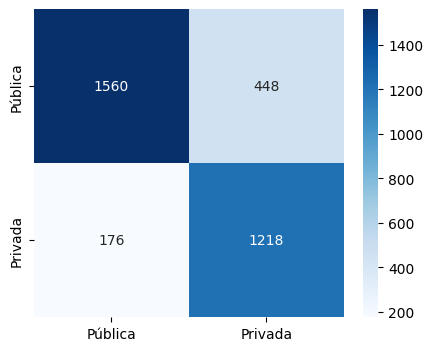

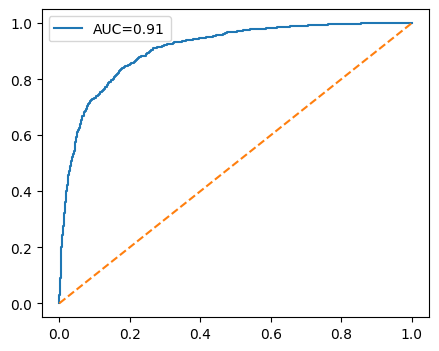

In [19]:



# Celda 8: Entrenar y evaluar (sin cambios)

model = DenseNetPrivacy(config["NUM_CLASSES"], config["DROPOUT_RATE"]).to(config["DEVICE"])
print("Params entrenables:", sum(p.numel() for p in model.parameters() if p.requires_grad))

model, hist = train_and_validate(model, train_loader, val_loader, class_weights, config)
best_t = find_best_threshold(model, val_loader, config["DEVICE"])
evaluate(model, test_loader, config["DEVICE"], config["CLASS_NAMES"], thr=best_t)


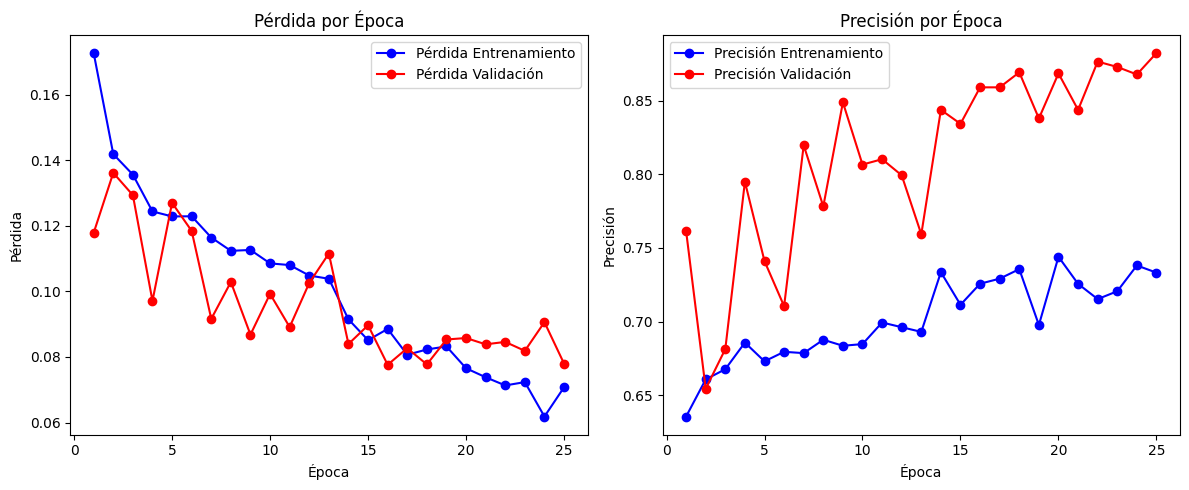


Acc (t=0.56): 0.8166
              precision    recall  f1-score   support

     Pública       0.90      0.78      0.83      2008
     Privada       0.73      0.87      0.80      1394

    accuracy                           0.82      3402
   macro avg       0.81      0.83      0.81      3402
weighted avg       0.83      0.82      0.82      3402



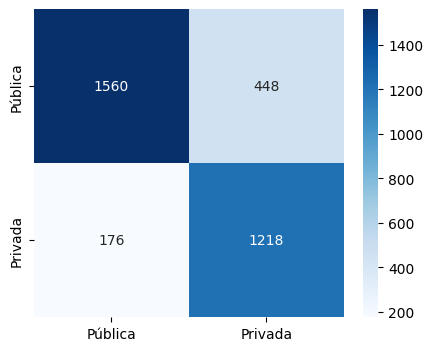

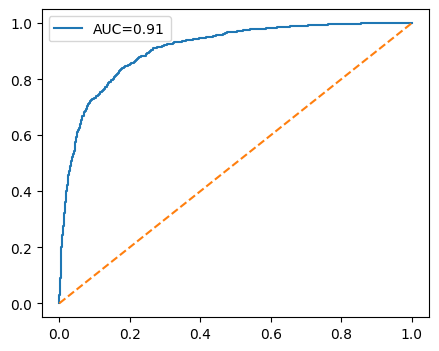

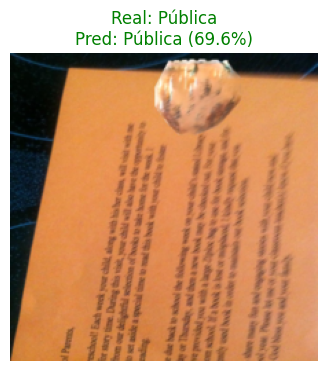

In [20]:
# Celda 9: Visualización de resultados

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 1. Curvas de pérdida y precisión
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Pérdida Entrenamiento')
    plt.plot(epochs, history['val_loss'],   'ro-', label='Pérdida Validación')
    plt.title('Pérdida por Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    # Precisión
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Precisión Entrenamiento')
    plt.plot(epochs, history['val_acc'],   'ro-', label='Precisión Validación')
    plt.title('Precisión por Época')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Llama a la función:
plot_training_history(hist)


# 2. Evaluación en test (ya imprime classification_report, matriz y ROC/AUC)
evaluate(model, test_loader, config['DEVICE'], config['CLASS_NAMES'], thr=best_t)


# 3. Mostrar ejemplo de predicción
def show_prediction_example(model, loader, device, class_names, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
    model.eval()
    # obtenemos un batch
    images, labels = next(iter(loader))
    img, true_lbl = images[0], labels[0].item()

    # predecir
    with torch.no_grad():
        out = model(img.unsqueeze(0).to(device))
        prob = F.softmax(out, dim=1)[0].cpu().numpy()
        pred_lbl = int(np.argmax(prob))

    # des-normalizar para mostrar
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = img_np * np.array(std) + np.array(mean)
    img_np = np.clip(img_np, 0, 1)

    plt.figure(figsize=(4, 4))
    plt.imshow(img_np)
    color = 'green' if pred_lbl == true_lbl else 'red'
    plt.title(
        f"Real: {class_names[true_lbl]}\n"
        f"Pred: {class_names[pred_lbl]} ({prob[pred_lbl]*100:.1f}%)",
        color=color
    )
    plt.axis('off')
    plt.show()

# Llamada
show_prediction_example(model, test_loader, config['DEVICE'], config['CLASS_NAMES'])
